# Auto-encoder


In [ ]:
###### -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.utils import ber_performance, get_basic_channel_fct, show_ber, get_all_possible_words

# Configuration
MODULATION = 'BPSK'
FEC_MATRIX = 'POLAR_8_16'

# Load data
k = 8
n = 16

def train_autoencoder(EbN0dB, nb_epochs=100_000):
    # Create models
    # Encoder
    encoder_model=Sequential()
    encoder_model.add(Dense(32, activation='relu', input_dim=k))
    encoder_model.add(Dense(64, activation='relu'))
    encoder_model.add(Dense(128, activation='relu'))
    encoder_model.add(Dense(n, activation='tanh'))

    # Decoder
    decoder_model=Sequential()
    decoder_model.add(Dense(10*2**k, activation='relu', input_dim=n))
    decoder_model.add(Dense(2**k, activation='softmax'))

    # Merge both to autoencoder
    noise_std = np.sqrt(0.5*(n/k)*(1 / 1)*(1/10**(EbN0dB/10)))
    noisy_model=Sequential()
    noisy_model.add(encoder_model)
    noisy_model.add(GaussianNoise(noise_std, input_shape=(n,)))
    noisy_model.add(decoder_model)

    noisy_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(noisy_model.summary())
    
    # Create labels for one-hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    t = time.time()
    noisy_history = noisy_model.fit(
        np.array(list(get_all_possible_words(8))), 
        np.array(labels), 
        epochs=nb_epochs, 
        verbose=0
    )
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')
    
    # Save models
    encoder_model.save(f'networks/autoencoder/autoencoder_encoder_{EbN0dB}.h5')
    decoder_model.save(f'networks/autoencoder/autoencoder_decoder_{EbN0dB}.h5')

if __name__ == '__main__':
#     train_autoencoder(-5)
#     train_autoencoder(0)
#     train_autoencoder(4)
    train_autoencoder(5)
    train_autoencoder(6)
    train_autoencoder(7)
    train_autoencoder(8)
    

C:\Users\Thibault\Anaconda3\envs\PythonGPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Start simulation with network trained at 5 dB
Start EbN0 1/20 [0.0] /1500 [73][143][206][274][358][442][532][658][753][838][971][1054][1156][1232][1324][1386][1500] | Ended in 0.33 s
Start EbN0 2/20 [0.21] /1500 [72][174][263][345][448][523][619][694][780][852][956][1028][1114][1195][1270][1387][1475][1557] | Ended in 0.24 s
Start EbN0 3/20 [0.42] /1500 [76][145][216][304][382][462][547][628][706][781][850][943][995][1051][1121][1196][1260][1334][1400][1489][1552] | Ended in 0.29 s
Start EbN0 4/20 [0.63] /1500 [53][130][190][238][296][375][455][501][577][643][702][784][851][932][1023][1078][1147][1230][1274][1339][1397][1465][1530] | Ended in 0.28 s
Start EbN0 5/20 [0.84] /1500 [61][122][183][248][303][390][445][501][549][610][670][717][776][844][901][964][1017][1081][1139][1211][1276][1327][1387][1456][1506] | Ended in 0.33 s
Start EbN0 6/20 [1.05] /1500 [50][100][166][229][305][350][400][447][494][549][628][682][742][795][860][921][977][1035][1105][1172][1227][1285][1356][1416][1452

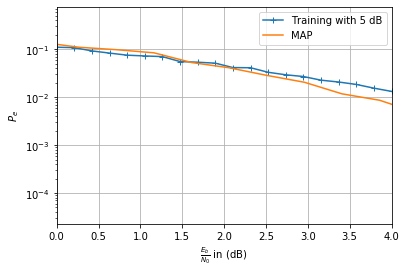

Elapsed : 15.18 s


In [12]:
# -*- coding: utf-8 -*-
import os
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import load_model

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode, TransmitterMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber, get_fec_matrix, get_all_possible_words

# Configuration
MODULATION = 'BPSK'
FEC_MATRIX = 'POLAR_8_16'
EbN0dBs = np.linspace(0, 4, 20)

G = get_fec_matrix(FEC_MATRIX)
channel = AWGNChannel(MODULATION, G)

k = np.size(G, 0)
n = np.size(G, 1)

block_elements = list(get_all_possible_words(k))

def get_channel_fct(encoder_model, decoder_model):
    def channel_fct(b, EbN0dB):
            # Encoder
            c = encoder_model.predict(np.array(np.split(b, len(b) // k)))
            c = c.flatten()

            # Channel
            d = channel.process(c, EbN0dB)

            # Decoder
            b_r = decoder_model.predict(np.array(np.split(d, len(d) // n)))
            b_r = np.array(list(map(lambda x: block_elements[np.argmax(x)], b_r)))
            b_r = b_r.flatten()

            return b_r, c, d
        
    return channel_fct

    
if __name__ == '__main__':
    t = time.time()
    
    # Get all trained networks
    elts = {}
    for file in os.listdir("networks/autoencoder"):
        if file.endswith(".h5"):
            [_, elt_type, elt_db] = file.replace('.h5', '').split('_')
            if elt_db not in elts.keys():
                elts[elt_db] = {}
            
            elts[elt_db][elt_type] = load_model(f'networks/autoencoder/{file}')
    
    # Plot results
    [EbN0dBs_C, BER_C] = np.loadtxt('BER_G_MAP.csv', delimiter=',')
    
    plt.figure()
    
    # Simulation
    legend = []
    symbols = ['+', 'x', 'o', '*']
    for (i, training_EbN0dB) in enumerate(elts.keys()):
        print(f'\nStart simulation with network trained at {training_EbN0dB} dB')
        legend.append(f'Training with {training_EbN0dB} dB')
        
        BER = ber_performance(
            EbN0dBs,
            get_channel_fct(
                elts[training_EbN0dB]['encoder'], 
                elts[training_EbN0dB]['decoder']
            ),
            k * 100,
            1500
        )
        plt.plot(EbN0dBs, BER, symbols[i % len(symbols)] + '-')

    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(legend + ['MAP'])
    plt.grid()
    
    plt.xlabel('$\\frac{E_b}{N_0}$ in (dB)')
    plt.ylabel('$P_e$')
    plt.yscale('log')
    plt.xlim(np.min(EbN0dBs), np.max(EbN0dBs))
    
    plt.show()
    
    # Save results
#     np.savetxt(
#         f'outputs/BER_autoencoder.csv', 
#         [np.array(EbN0dBs), np.array(BER)], delimiter=','
#     )
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')
